In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 80.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "silica, 7nm pores, 43 wt.% PEI"
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[0, 1, 0, 1],
     [0, 1, 0, 1],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["30-2"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[5.0588e+02, 5174.770, 9492.830, 14695.640],
             [0, 5.9944e+03, 1.1229e+04, 1.8612e+04],
             [0, 709+8460, 6469+8460, 6867+8460, 12698+8460]]
DT = [[0], [0, 18900, 19080], [0, 8460]]
# indices (columns) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI43/"
FILES = [["12-18_M2_TBD039_PEI43_70C_NCNC.TXT"],
         ["12-19_M3_TBD039_PEI43_50C_NCN.TXT", "12-19_M4_TBD039_PEI43_50C_C_zwischensweep.TXT", "12-19_M5_TBD039_PEI43_50C_C.TXT"],
         ["12-20_M3_TBD039_PEI43_30C_N-20min.TXT", "12-20_M4_TBD039_PEI43_30C_20min-nCCN.TXT"]]
DATA = [[],[],[]]

for m, files in enumerate(FILES) :
    for i, file in enumerate(files) :
        data_ = np.genfromtxt(folder+file, delimiter='\t', skip_header=4)
        data_[:,-1] = (data_[:,-1] + DT[m][i])
        if not i :
            after = data_[:,-1] >= GASCHANGE[m][0]
            data = data_[after]
        else :
            data = np.append(data[:], data_[:], axis=0)

     # add final time to GASCHANGE, needed in main and make time unit hours
    GASCHANGE[m].append(data[-1,-1])
    GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
    data[:,-1] = data[:,-1] / 60.
    DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5]
def extract_interpolate_and_derivative(data, num_points=1000):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]
        
        interpolator_er_k = interp1d(t_k, er_k, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolator_ei_k = interp1d(t_k, ei_k, kind='linear', bounds_error=False, fill_value=np.nan)

        er_int.append(interpolator_er_k(t_test_set))
        ei_int.append(interpolator_ei_k(t_test_set))

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# don't forget to change the individual terms in the plot function if fitfunction is edited

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon$", "$\\alpha$", "$\\omega_p$ [Hz]", 
            "$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]"]

# starting initial guess for every run
p0_start = np.array([
    # 70
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 50
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 30
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5]])

# boundaries
i_ = np.inf
wi1, wf1 = 0.0, 1.0
wi2, wf2 = 1.0, 4e4
wi3, wf3 = 4e4, 1e7
bounds = ([0.0, 0.0, wi1, 0.0, 0.0, wi3], [i_, 1.0, wf2, i_, 1.0, wf3])

# functions
def der_real (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2), 
            imag(x, de, a, wp, de_2, a_2, wp_2))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:])
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')

In [5]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(1.), np.log(6e4), 100)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        mask_area = np.zeros_like(lnw_area)
        y = np.exp(fitf((lnw_area, mask_area), *popt))
        a = np.trapezoid(y, np.exp(lnw_area))
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            mask_area = np.zeros_like(lnw_area)
            y = np.exp(fitf((lnw_area, mask_area), *popt))
            a = np.trapezoid(y, np.exp(lnw_area))
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_ylabel("$\\epsilon_{der} = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}$")

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = SAMPLE + "  |  "+ id +"  |  "+timestr
    plt.title(title)
    ax1.set_xlabel("AC angular frequency $\omega$ [Hz]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.9))
    #plt.savefig("results20/fits/"+id+".png", bbox_inches='tight')
    plt.show()

fit score 22668.0
fit parameters [6154000.0, 0.7131, 1.745e-06, 3.488, 0.5865, 64220.0]


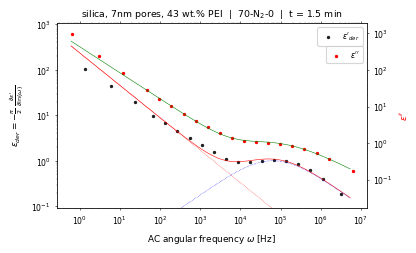

FALLBACK 1:  23795.0
fit score 25322.0
fit parameters [6981000.0, 0.7184, 1.763e-06, 3.504, 0.5859, 65270.0]


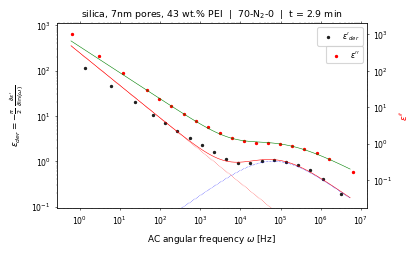

FALLBACK 1:  26244.0
FALLBACK 1:  27713.0
FALLBACK 1:  29031.0
FALLBACK 1:  31789.0
FALLBACK 1:  35104.0
FALLBACK 1:  35923.0
FALLBACK 1:  36034.0
FALLBACK 1:  35302.0
FALLBACK 1:  34814.0
FALLBACK 1:  33634.0
FALLBACK 1:  33253.0
FALLBACK 1:  32773.0
FALLBACK 1:  32891.0
FALLBACK 1:  33308.0
FALLBACK 1:  34997.0
FALLBACK 1:  35907.0
FALLBACK 1:  35299.0
fit score 34420.0
fit parameters [12320000.0, 0.7399, 1.787e-06, 3.54, 0.5888, 73360.0]


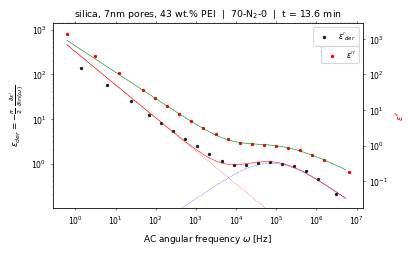

FALLBACK 1:  33513.0
FALLBACK 1:  32493.0
FALLBACK 1:  31615.0
FALLBACK 1:  31320.0
FALLBACK 1:  33410.0
FALLBACK 1:  35189.0
FALLBACK 1:  36427.0
FALLBACK 1:  37758.0
FALLBACK 1:  39130.0
FALLBACK 1:  42150.0
FALLBACK 1:  43542.0
FALLBACK 1:  41949.0
FALLBACK 1:  41412.0
FALLBACK 1:  41053.0
FALLBACK 1:  41892.0
FALLBACK 1:  43466.0
FALLBACK 1:  47201.0
FALLBACK 1:  49275.0
FALLBACK 1:  48754.0
FALLBACK 1:  48121.0
FALLBACK 1:  47498.0
FALLBACK 1:  46763.0
FALLBACK 1:  45257.0
FALLBACK 1:  42914.0
FALLBACK 1:  42824.0
FALLBACK 1:  43894.0
FALLBACK 1:  44965.0
FALLBACK 1:  46284.0
FALLBACK 1:  48876.0
FALLBACK 1:  49957.0
FALLBACK 1:  49993.0
FALLBACK 1:  48309.0
FALLBACK 1:  47473.0
FALLBACK 1:  48195.0
FALLBACK 1:  48814.0
FALLBACK 1:  49023.0
FALLBACK 1:  49231.0
FALLBACK 1:  48511.0
FALLBACK 1:  47498.0
FALLBACK 1:  47925.0
FALLBACK 1:  48466.0
FALLBACK 1:  48931.0
FALLBACK 1:  49407.0
FALLBACK 1:  49263.0
FALLBACK 1:  48171.0
fit score 62549.0
fit parameters [22320000.0, 0.7583, 1

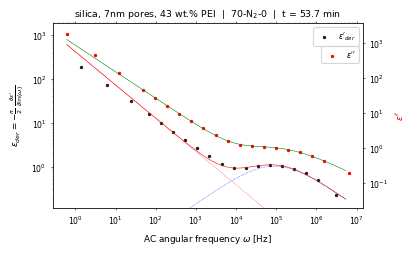

fit score 65943.0
fit parameters [24190000.0, 0.7615, 1.758e-06, 3.552, 0.5927, 91000.0]


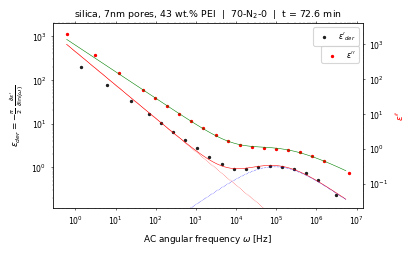

fit score 83205.0
fit parameters [25670000.0, 0.7746, 1.531e-06, 3.496, 0.5629, 70240.0]


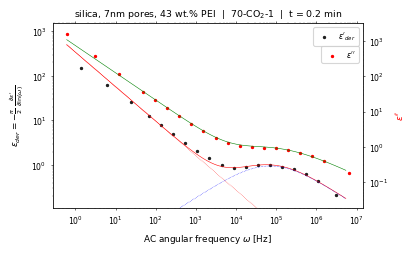

fit score 144957.0
fit parameters [13270000.0, 0.7576, 1.094e-06, 3.525, 0.5379, 53320.0]


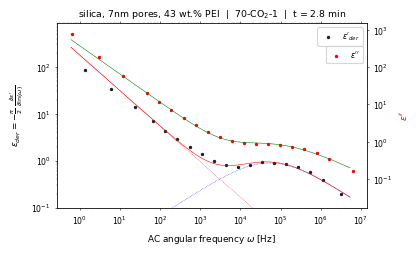

fit score 143042.0
fit parameters [6651000.0, 0.7376, 1.076e-06, 3.536, 0.51, 45490.0]


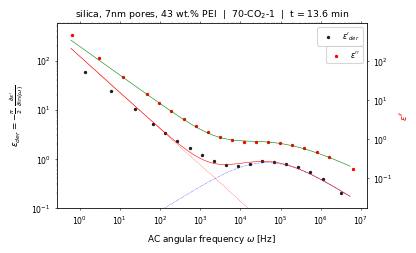

fit score 449175.0
fit parameters [7564000.0, 0.77, 2.196e-06, 3.624, 0.484, 46920.0]


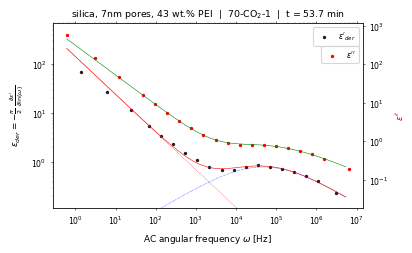

fit score 584311.0
fit parameters [8306000.0, 0.7757, 2.226e-06, 3.639, 0.4795, 46600.0]


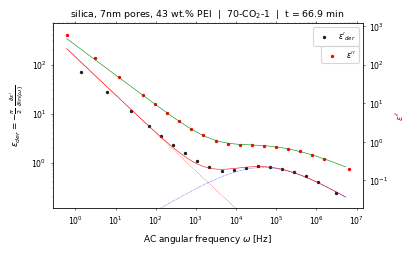

fit score 881811.0
fit parameters [8318000.0, 0.7799, 2.369e-06, 3.67, 0.4762, 45270.0]


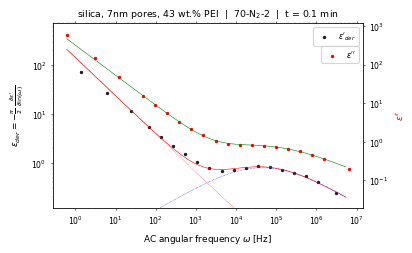

fit score 432654.0
fit parameters [5261000.0, 0.7686, 3.513e-06, 3.819, 0.4801, 40000.0]


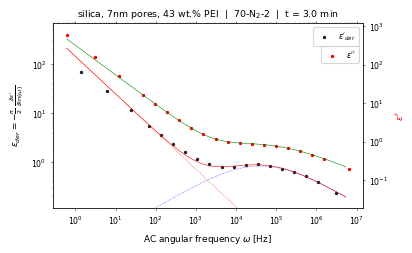

fit score 145264.0
fit parameters [11600000.0, 0.7472, 1.373e-06, 4.011, 0.4975, 42640.0]


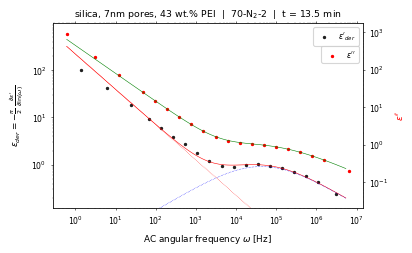

FALLBACK 1:  48549.0
FALLBACK 1:  46461.0
FALLBACK 1:  45492.0
FALLBACK 1:  44553.0
FALLBACK 1:  39853.0
FALLBACK 1:  36549.0
FALLBACK 1:  35361.0
FALLBACK 1:  34258.0
FALLBACK 1:  33644.0
FALLBACK 1:  33255.0
FALLBACK 1:  32847.0
FALLBACK 1:  32680.0
FALLBACK 1:  32564.0
FALLBACK 1:  32400.0
FALLBACK 1:  36373.0
FALLBACK 1:  38155.0
FALLBACK 1:  39980.0
FALLBACK 1:  41854.0
FALLBACK 1:  41764.0
FALLBACK 1:  39549.0
FALLBACK 1:  37455.0
FALLBACK 1:  35296.0
FALLBACK 1:  30211.0
FALLBACK 1:  30281.0
FALLBACK 1:  30346.0
FALLBACK 1:  30462.0
FALLBACK 1:  30688.0
FALLBACK 1:  31254.0
FALLBACK 1:  34271.0
FALLBACK 1:  39417.0
FALLBACK 1:  39672.0
FALLBACK 1:  38307.0
FALLBACK 1:  36970.0
FALLBACK 1:  35412.0
FALLBACK 1:  34138.0
FALLBACK 1:  35690.0
FALLBACK 1:  37322.0
FALLBACK 1:  36243.0
FALLBACK 1:  35619.0
FALLBACK 1:  34921.0
FALLBACK 1:  33781.0
FALLBACK 1:  33192.0
FALLBACK 1:  31709.0
FALLBACK 1:  30983.0
FALLBACK 1:  30133.0
FALLBACK 1:  29302.0
FALLBACK 1:  28495.0
FALLBACK 1:  

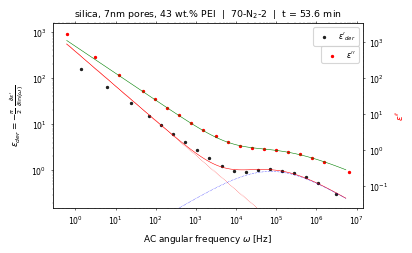

FALLBACK 1:  28084.0
FALLBACK 1:  27824.0
FALLBACK 1:  27490.0
FALLBACK 1:  28405.0
FALLBACK 1:  29326.0
FALLBACK 1:  30291.0
FALLBACK 1:  31336.0
FALLBACK 1:  31849.0
FALLBACK 1:  30467.0
FALLBACK 1:  25814.0
FALLBACK 1:  27270.0
FALLBACK 1:  30351.0
FALLBACK 1:  32086.0
FALLBACK 1:  33991.0
FALLBACK 1:  34038.0
FALLBACK 1:  33312.0
FALLBACK 1:  32409.0
FALLBACK 1:  31410.0
FALLBACK 1:  30717.0
FALLBACK 1:  31342.0
FALLBACK 1:  32573.0
FALLBACK 1:  33296.0
FALLBACK 1:  34228.0
FALLBACK 1:  34907.0
FALLBACK 1:  34230.0
FALLBACK 1:  33562.0
FALLBACK 1:  32911.0
FALLBACK 1:  32196.0
FALLBACK 1:  31440.0
FALLBACK 1:  31804.0
FALLBACK 1:  36221.0
FALLBACK 1:  27779.0
FALLBACK 1:  25992.0
FALLBACK 1:  27126.0
FALLBACK 1:  28292.0
FALLBACK 1:  29587.0
FALLBACK 1:  30937.0
FALLBACK 1:  31967.0
FALLBACK 1:  32127.0
FALLBACK 1:  32260.0
FALLBACK 1:  31450.0
FALLBACK 1:  28285.0
FALLBACK 1:  24813.0
FALLBACK 1:  27622.0
FALLBACK 1:  27502.0
FALLBACK 1:  27336.0
FALLBACK 1:  27956.0
FALLBACK 1:  

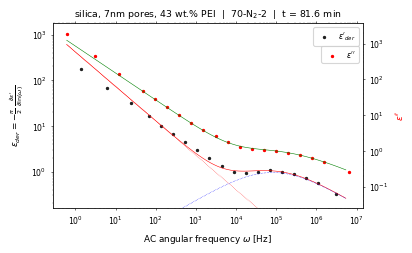

fit score 130993.0
fit parameters [30690000.0, 0.7811, 1.487e-06, 3.907, 0.4963, 62430.0]


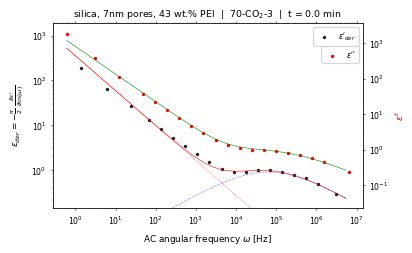

fit score 238090.0
fit parameters [17150000.0, 0.7692, 1.007e-06, 3.795, 0.4845, 50550.0]


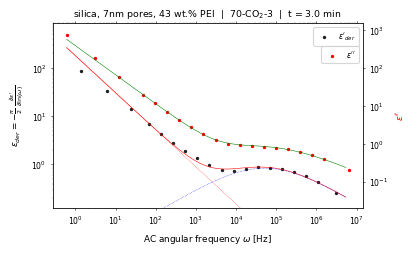

fit score 350401.0
fit parameters [12020000.0, 0.7666, 1.086e-06, 3.759, 0.4707, 43830.0]


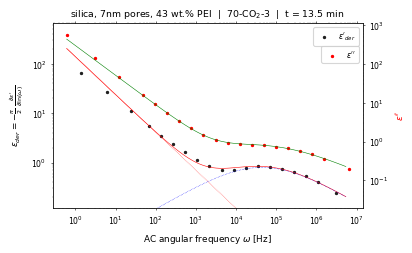

fit score 707435.0
fit parameters [8560000.0, 0.7747, 1.887e-06, 3.747, 0.4637, 41990.0]


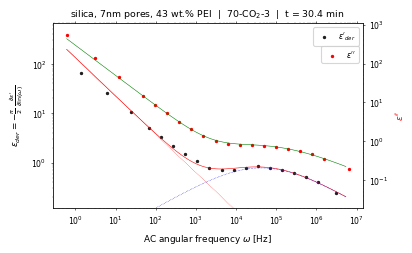

FALLBACK 1:  11743.0
FALLBACK 1:  11981.0
FALLBACK 1:  12770.0
FALLBACK 1:  14926.0
FALLBACK 1:  15573.0
FALLBACK 1:  16813.0
fit score 17178.0
fit parameters [668200.0, 0.6342, 1.922e-06, 3.887, 0.5155, 40000.0]


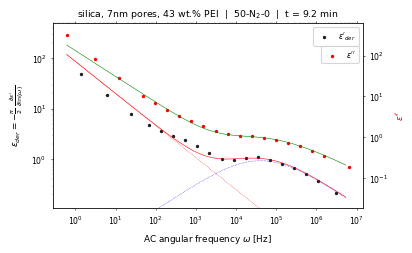

fit score 17536.0
fit parameters [673600.0, 0.6356, 2.006e-06, 3.903, 0.5146, 40000.0]


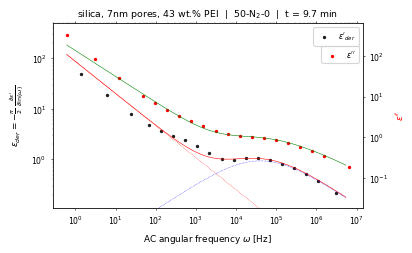

FALLBACK 1:  18283.0
FALLBACK 1:  19613.0
FALLBACK 1:  20679.0
fit score 23332.0
fit parameters [903900.0, 0.6458, 1.978e-06, 4.025, 0.507, 40000.0]


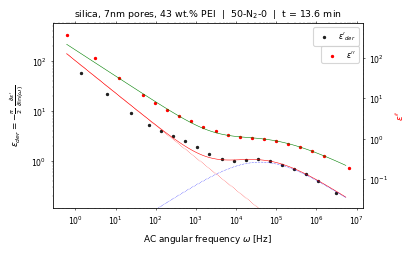

FALLBACK 1:  25725.0
FALLBACK 1:  27129.0
FALLBACK 1:  29240.0
FALLBACK 1:  31395.0
FALLBACK 1:  31411.0
FALLBACK 1:  31455.0
FALLBACK 1:  31507.0
FALLBACK 1:  32286.0
FALLBACK 1:  32960.0
FALLBACK 1:  34398.0
FALLBACK 1:  37800.0
FALLBACK 1:  39772.0
FALLBACK 1:  40596.0
FALLBACK 1:  41014.0
FALLBACK 1:  42205.0
FALLBACK 1:  42998.0
FALLBACK 1:  43506.0
FALLBACK 1:  44331.0
FALLBACK 1:  44696.0
FALLBACK 1:  45894.0
FALLBACK 1:  47156.0
FALLBACK 1:  48440.0
fit score 156103.0
fit parameters [3871000.0, 0.7016, 2.409e-06, 4.687, 0.4692, 40000.0]


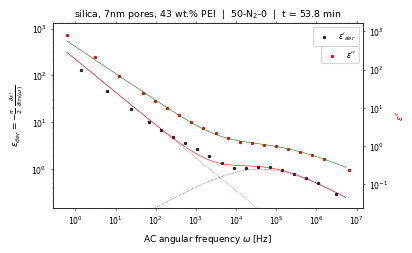

fit score 295104.0
fit parameters [6063000.0, 0.7123, 2.047e-06, 4.821, 0.4604, 40000.0]


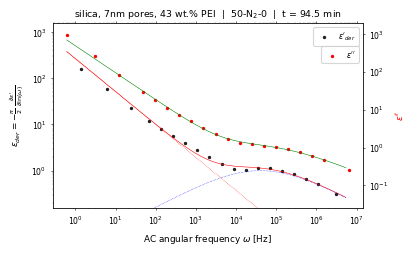

fit score 491322.0
fit parameters [3317000.0, 0.6942, 1.573e-06, 4.101, 0.4826, 40000.0]


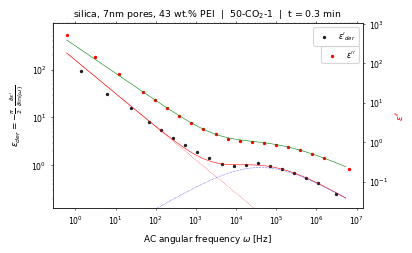

fit score 1178010.0
fit parameters [2599000.0, 0.705, 1.956e-06, 4.041, 0.4864, 40000.0]


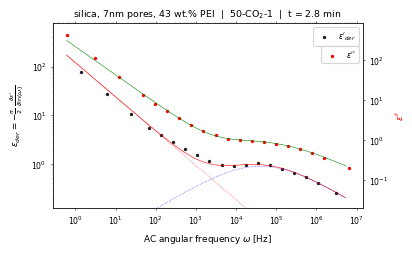

fit score 1348532.0
fit parameters [2082000.0, 0.7017, 2.004e-06, 3.888, 0.4874, 40000.0]


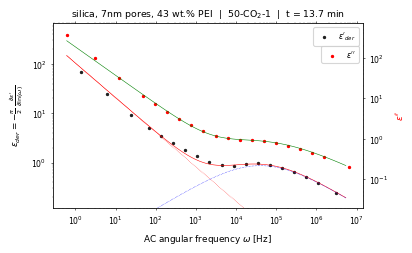

fit score 3244817.0
fit parameters [1424000.0, 0.7118, 3.993e-06, 3.802, 0.4859, 40000.0]


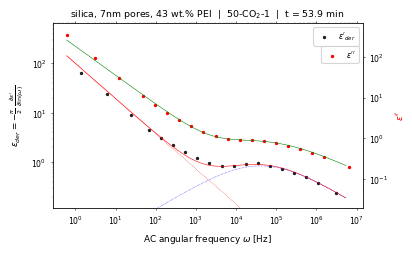

fit score 3741283.0
fit parameters [1393000.0, 0.7137, 4.147e-06, 3.767, 0.486, 40000.0]


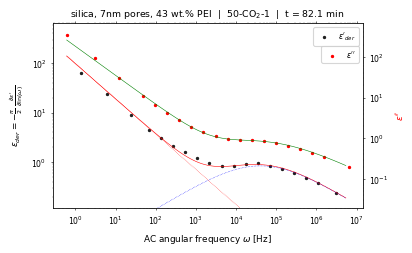

fit score 2587025.0
fit parameters [1203000.0, 0.716, 5.047e-06, 3.682, 0.4916, 40000.0]


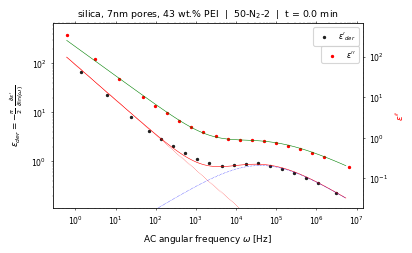

fit score 548640.0
fit parameters [798100.0, 0.6943, 4.126e-06, 3.41, 0.5123, 40000.0]


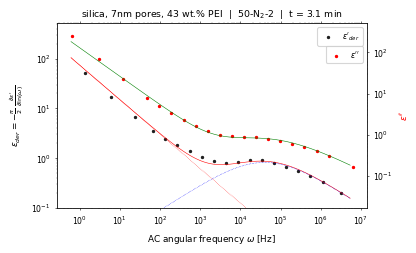

FALLBACK 1:  43231.0
fit score 40719.0
fit parameters [308100.0, 0.6454, 3.236e-06, 3.13, 0.528, 40000.0]


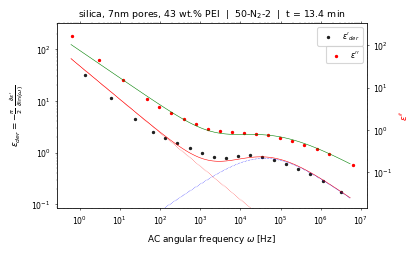

FALLBACK 1:  35508.0
FALLBACK 1:  33942.0
FALLBACK 1:  33127.0
FALLBACK 1:  32892.0
FALLBACK 1:  32815.0
FALLBACK 1:  32507.0
FALLBACK 1:  32194.0
FALLBACK 1:  32059.0
FALLBACK 1:  32236.0
FALLBACK 1:  32823.0
FALLBACK 1:  33629.0
FALLBACK 1:  34403.0
FALLBACK 1:  35043.0
FALLBACK 1:  35460.0
FALLBACK 1:  35757.0
FALLBACK 1:  36181.0
FALLBACK 1:  37106.0
FALLBACK 1:  37964.0
FALLBACK 1:  38779.0
FALLBACK 1:  39666.0
FALLBACK 1:  40584.0
FALLBACK 1:  41460.0
FALLBACK 1:  42364.0
FALLBACK 1:  43304.0
FALLBACK 1:  44541.0
FALLBACK 1:  45852.0
FALLBACK 1:  46904.0
FALLBACK 1:  47917.0
FALLBACK 1:  49373.0
fit score 482268.0
fit parameters [952100.0, 0.6858, 4.035e-06, 3.585, 0.5188, 40000.0]


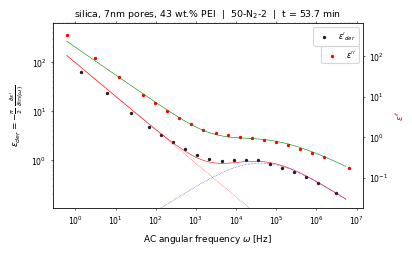

fit score 2576840.0
fit parameters [2819000.0, 0.7127, 3.312e-06, 3.943, 0.5105, 40000.0]


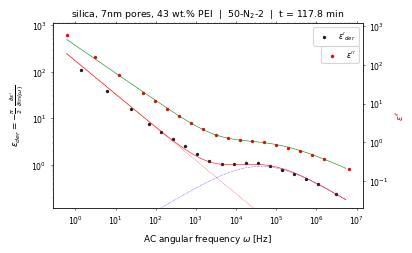

fit score 919955.0
fit parameters [1328000.0, 0.7333, 8.757e-06, 3.924, 0.5082, 40000.0]


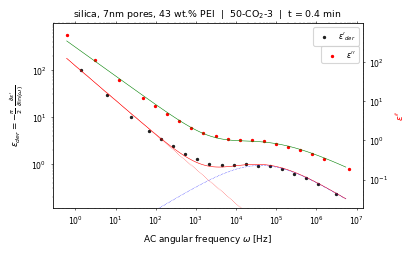

fit score 341048.0
fit parameters [759500.0, 0.6944, 4.828e-06, 3.459, 0.5173, 40000.0]


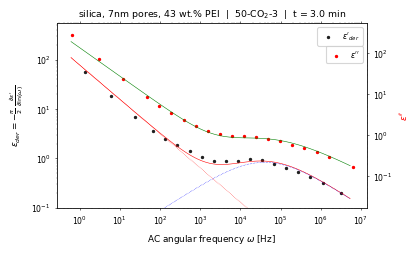

fit score 54459.0
fit parameters [284900.0, 0.6475, 3.508e-06, 3.054, 0.5312, 40000.0]


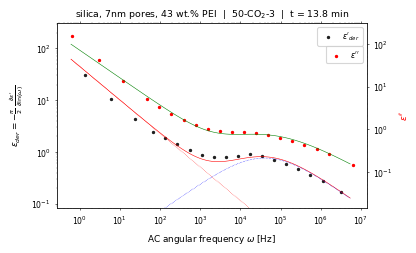

FALLBACK 1:  46892.0
FALLBACK 1:  46100.0
FALLBACK 1:  43373.0
FALLBACK 1:  46213.0
FALLBACK 1:  46826.0
FALLBACK 1:  47703.0
FALLBACK 1:  48567.0
FALLBACK 1:  49443.0
FALLBACK 1:  49734.0
FALLBACK 1:  49463.0
FALLBACK 1:  49114.0
FALLBACK 1:  49596.0
fit score 106766.0
fit parameters [279700.0, 0.6459, 3.494e-06, 3.146, 0.5156, 40000.0]


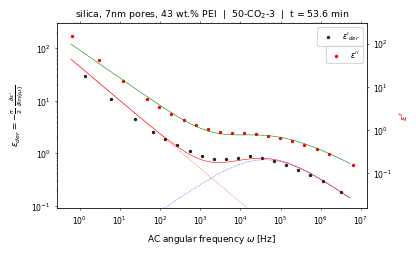

fit score 237086.0
fit parameters [432900.0, 0.6706, 3.813e-06, 3.245, 0.5091, 40000.0]


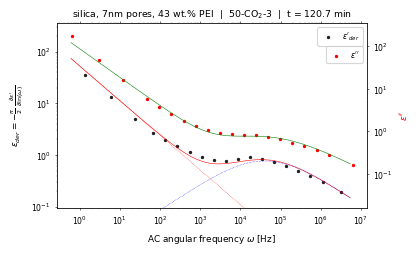

FALLBACK 1:  1052.0
FALLBACK 1:  1123.0
FALLBACK 1:  1212.0
FALLBACK 1:  1303.0
FALLBACK 1:  1339.0
FALLBACK 1:  1370.0
FALLBACK 1:  1410.0
FALLBACK 1:  1480.0
FALLBACK 1:  1539.0
FALLBACK 1:  1589.0
FALLBACK 1:  1616.0
FALLBACK 1:  1628.0
FALLBACK 1:  1684.0
FALLBACK 1:  2192.0
FALLBACK 1:  3345.0
FALLBACK 1:  3735.0
FALLBACK 1:  3977.0
FALLBACK 1:  4234.0
FALLBACK 1:  4501.0
FALLBACK 1:  5123.0
FALLBACK 1:  5781.0
FALLBACK 1:  6134.0
FALLBACK 1:  6875.0
FALLBACK 1:  7699.0
FALLBACK 1:  8058.0
FALLBACK 1:  8475.0
FALLBACK 1:  8974.0
FALLBACK 1:  9611.0
FALLBACK 1:  10276.0
FALLBACK 1:  10915.0
FALLBACK 1:  12796.0
FALLBACK 1:  13404.0
FALLBACK 1:  14666.0
FALLBACK 1:  15754.0
FALLBACK 1:  16905.0
fit score 18072.0
fit parameters [223200.0, 0.6176, 2.863e-06, 2.699, 0.5235, 40000.0]


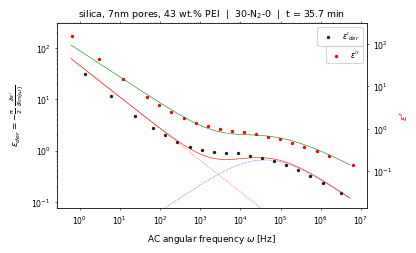

fit score 19311.0
fit parameters [230200.0, 0.6197, 2.958e-06, 2.713, 0.5233, 40000.0]


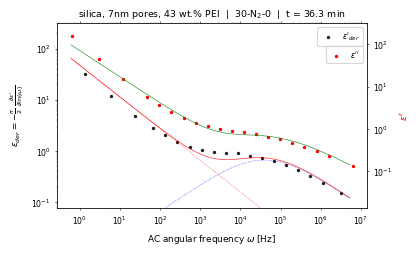

FALLBACK 1:  20513.0
fit score 20513.0
fit parameters [241500.0, 0.6217, 2.959e-06, 2.727, 0.5231, 40000.0]


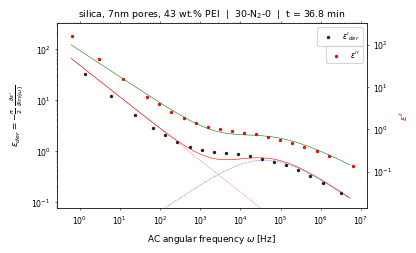

FALLBACK 1:  21687.0
FALLBACK 1:  24327.0
FALLBACK 1:  25789.0
FALLBACK 1:  27229.0
FALLBACK 1:  28622.0
FALLBACK 1:  31463.0
FALLBACK 1:  33235.0
FALLBACK 1:  39207.0
FALLBACK 1:  41830.0
fit score 96483.0
fit parameters [640000.0, 0.671, 4.357e-06, 3.103, 0.517, 40000.0]


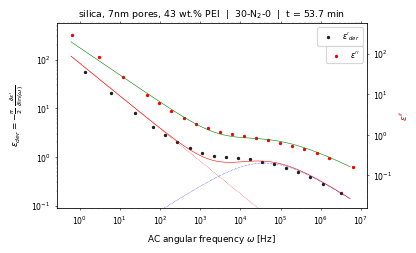

fit score 10781380.0
fit parameters [6478000.0, 0.773, 8.794e-06, 3.931, 0.5048, 40000.0]


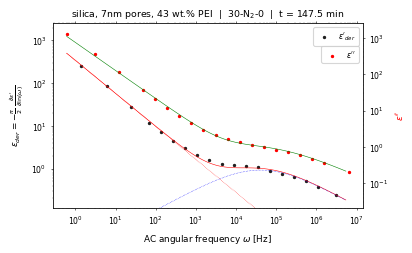

fit score 7130441.0
fit parameters [3050000.0, 0.7745, 2.266e-05, 3.937, 0.5003, 40000.0]


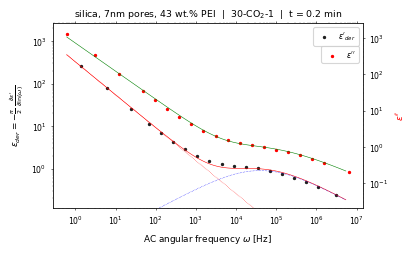

fit score 6535735.0
fit parameters [3073000.0, 0.7598, 1.27e-05, 3.708, 0.5096, 40000.0]


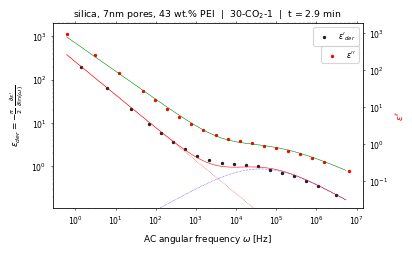

fit score 2437061.0
fit parameters [2044000.0, 0.7468, 1.107e-05, 3.458, 0.5211, 40000.0]


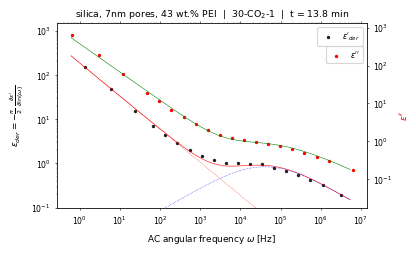

fit score 1809383.0
fit parameters [1170000.0, 0.7252, 1.123e-05, 3.393, 0.5183, 40000.0]


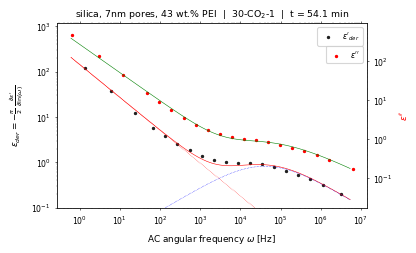

fit score 4915023.0
fit parameters [1554000.0, 0.7369, 1.266e-05, 3.56, 0.5116, 40000.0]


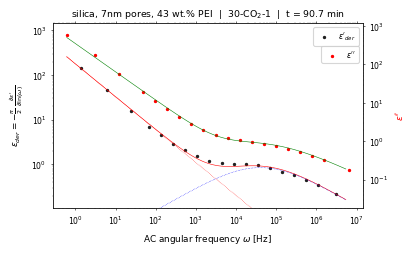

fit score 5564143.0
fit parameters [1223000.0, 0.7431, 2.055e-05, 3.58, 0.5116, 40000.0]


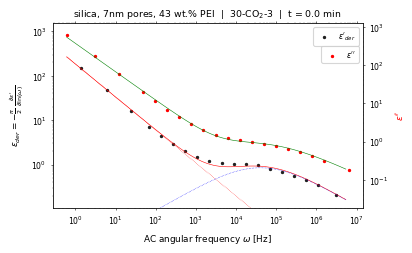

fit score 3671109.0
fit parameters [1357000.0, 0.7383, 1.396e-05, 3.464, 0.5174, 40000.0]


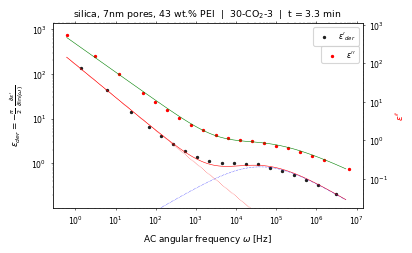

fit score 1298167.0
fit parameters [1001000.0, 0.7254, 1.226e-05, 3.283, 0.5262, 40000.0]


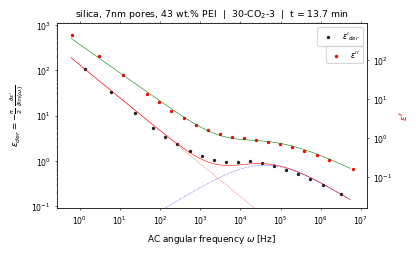

fit score 1584645.0
fit parameters [932800.0, 0.7149, 1.006e-05, 3.329, 0.5188, 40000.0]


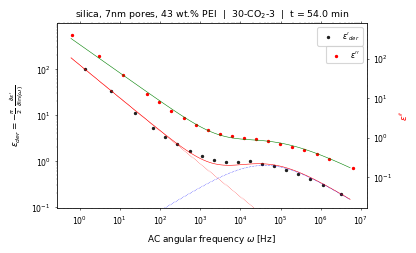

fit score 3587919.0
fit parameters [1062000.0, 0.7311, 1.624e-05, 3.529, 0.5134, 40000.0]


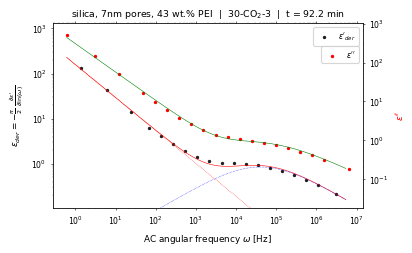

fit score 4247094.0
fit parameters [1003000.0, 0.7339, 1.914e-05, 3.553, 0.5134, 40000.0]


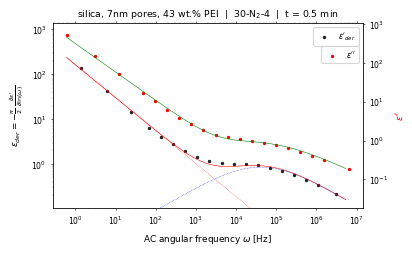

fit score 2645440.0
fit parameters [996000.0, 0.7321, 1.612e-05, 3.438, 0.5178, 40000.0]


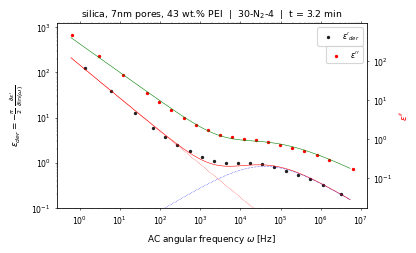

fit score 787053.0
fit parameters [799100.0, 0.7168, 1.106e-05, 3.209, 0.529, 40000.0]


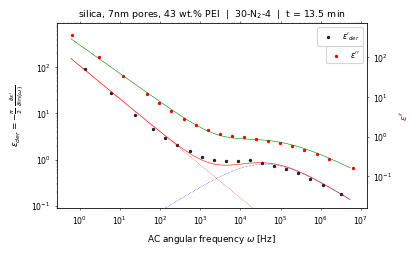

fit score 1407501.0
fit parameters [803700.0, 0.7108, 9.9e-06, 3.303, 0.5206, 40000.0]


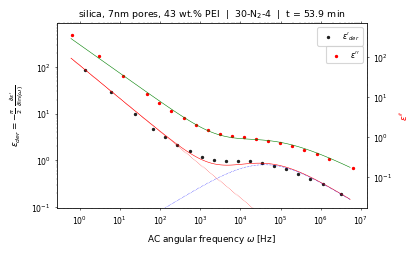

fit score 2266169.0
fit parameters [1497000.0, 0.7508, 2.356e-05, 3.686, 0.5121, 40000.0]


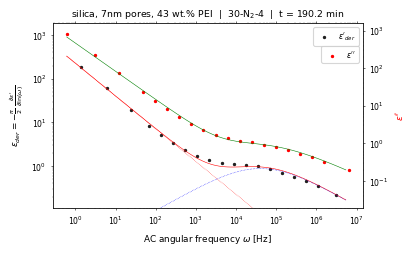

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

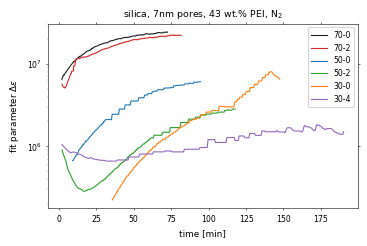

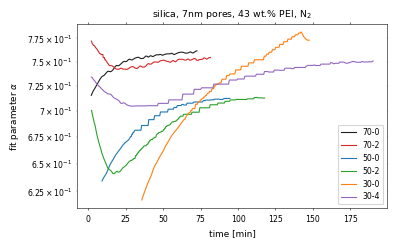

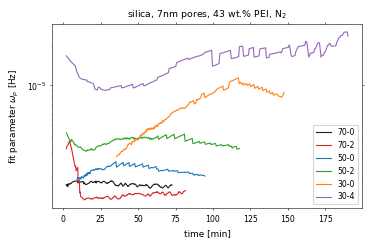

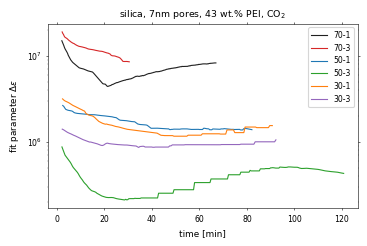

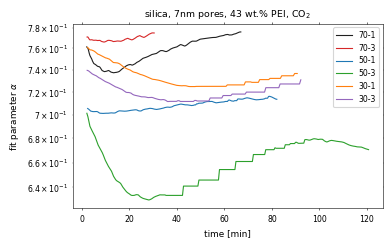

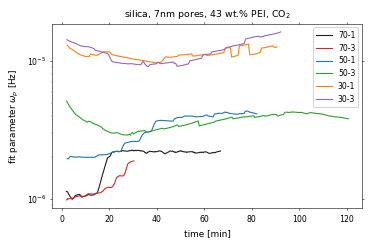

In [7]:
### Plot time evolution of fit parameters

# j: run with specific temp and gas
# i: parameters

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

p_in = [0, 2, 3, 5, 6, 8]

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j], P_ALL_[j][i]

            plt.plot(x, y, label=label, linewidth=1)
            plt.title(SAMPLE + ", " + gas)

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/paramkin/"+gas+" "+parameter+".png", bbox_inches='tight')
        plt.show()


NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


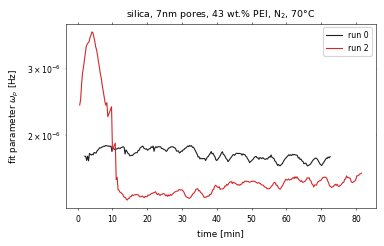

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


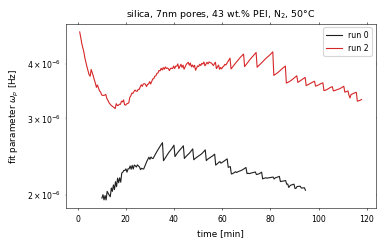

NameError :  name 'skdfjsio' is not defined
NameError :  name 'skdfjsio' is not defined


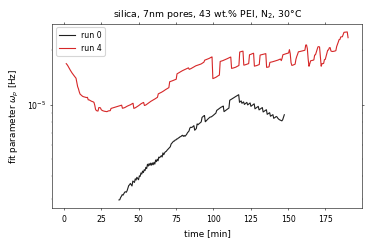

In [8]:
### parameters by temperature

def exp(x, a, b, c) :
    return np.exp(-b*(x-a)) + c

for i, parameter in enumerate(p_labels[:-3]) :
    if i != 2 :
        continue

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('log')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            t, p = DT_ALL[j][2:], P_ALL[j][i][2:]
            #n = np.argmin(a)
            #t, a = t[n:], a[n:]
            plt.plot(t, p, label=label, linewidth=1)
            fitt1 = t < 10
            fitt2 = t > 15

            fitf = exp
            try :
                ldgnd = skdfjsio
                popt1, _ = curve_fit(fitf, t[fitt1], a[fitt1], bounds=((0., 0., 0.), (i_, i_, i_)))
                popt2, _ = curve_fit(fitf, t[fitt2], a[fitt2], bounds=((0., 0., 0.), (i_, i_, i_)))

                y1 = fitf(t, *popt1)
                y2 = fitf(t, *popt2)
                #yp = expp(DT, *popt[:3])
                #yn = expn(DT, *popt[2:])
                plt.plot(t, y1, linewidth=0.5, color='b')
                plt.plot(t, y2, linewidth=0.5, color='g')
                #plt.plot(DT, yp)
                #plt.plot(DT, yn)
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.title(SAMPLE + ", " + id[3:-2] + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("fit parameter " + parameter)
        plt.legend()
        #plt.savefig("results20/omegaevo/"+gas+" "+temp+".png", bbox_inches='tight')
        plt.show()

70
[4.80218469e+02 6.43713902e+01 7.09332288e+04 8.99956314e+00
 6.56194351e+01]
70


/tmp/ipykernel_186479/3269432152.py:6: RuntimeWarning: overflow encountered in exp
  return -np.exp(-(x-a)/b) + c - np.exp(-(x-e)/d)


RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


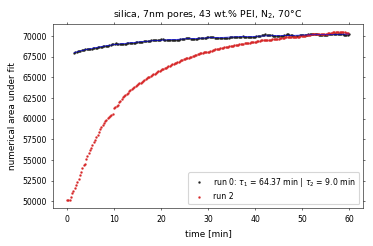

50
[-1.01976655e+03  1.68282066e+04  7.83281358e+04  3.52471680e+01
  3.47111636e+02]
50
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


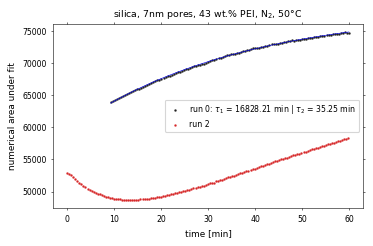

30
[-1.98504982e+03  2.15054514e+03  7.02301593e+04  6.75525274e+01
  7.22931919e+02]
30
[-4.25725539e+01  2.18083009e+00  5.19569486e+04  1.22839428e+01
 -4.13295547e+04]


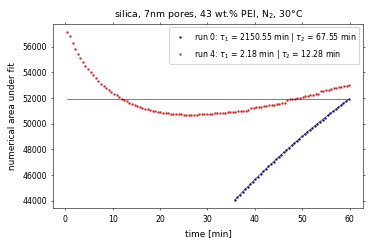

70
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
70
[8.17162106e+01 9.33065394e+00 4.97689631e+04 5.83959918e-01
 5.20464227e+00]


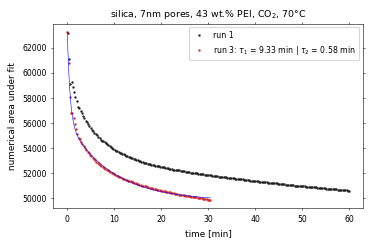

50
[1.18161643e+01 1.39771626e+00 5.43203985e+04 1.80278564e+01
 1.55175305e+02]
50
[-1.53897869e+02  1.06917873e+04  4.68219837e+04  4.73898884e+00
  4.44480355e+01]


/tmp/ipykernel_186479/3269432152.py:4: RuntimeWarning: overflow encountered in exp
  return np.exp(-(x-a)/b) + c + np.exp(-(x-e)/d)


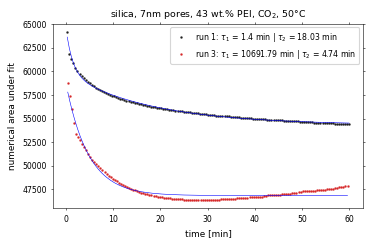

30
[7.75340030e+01 8.35371199e+00 5.47675766e+04 8.56343106e+04
 3.86492914e+03]
30
[ 5.55306965e+01  6.41153139e+00  5.26878871e+04  1.92563725e+03
 -3.56916648e+04]


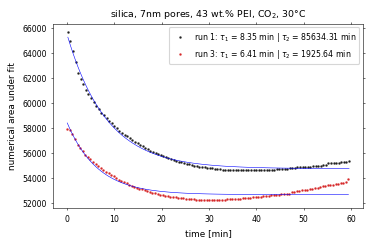

In [9]:
### Plot area

def exp(x, a, b, c, d, e) :
    return np.exp(-(x-a)/b) + c + np.exp(-(x-e)/d)
def expn(x, a, b, c, d, e) :
    return -np.exp(-(x-a)/b) + c - np.exp(-(x-e)/d)

p01 = [[3.13982775e+02, 3.54885096e+01, 1.81290828e+04, 5.70343000e+00, 5.24520412e+01],
    [1.18472451e+01, 1.11436920e+00, 1.98973972e+05, 6.78821372e+01, 7.78590720e+02],
    [1.50365926e+01, 2.43106947e+00, 2.61572150e+03, 1.94785320e+01, 1.12435019e+02]]
p02 = [[  13.43631687,    2.49961102, 1912.34579601,   15.56716046,   86.67703241],
    [2.47479126e+00, 3.42108290e-01, 1.32737618e+03, 5.26595996e+00, 3.37606163e+01],
    [  94.96847939,   16.59200303, 1383.53486793,    1.82029623,  10.93245541]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            print (temp)
            t, a = DT_ALL[j], A_ALL[j]
            fitt = t < 60
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                fitf = expn
                p0 = p01[T_i]
            else :
                fitf = exp
                p0 = p02[T_i]
            try :
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                print(popt)
                plt.plot(t, fitf(t, *popt), color="b")

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)
            plt.title(SAMPLE + ", " + gas + ", " + temp + "°C")

        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20/areaevo/"+gas+" "+temp+"2.png", bbox_inches='tight')
        plt.show()

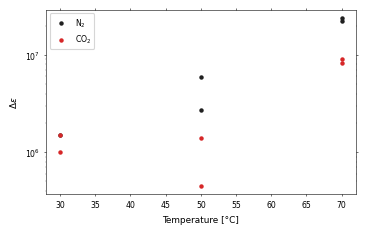

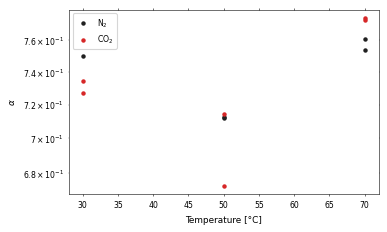

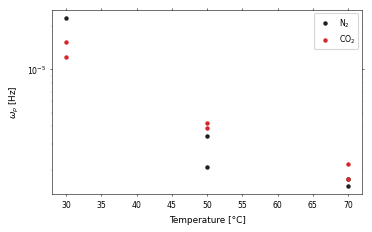

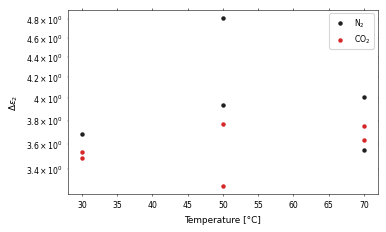

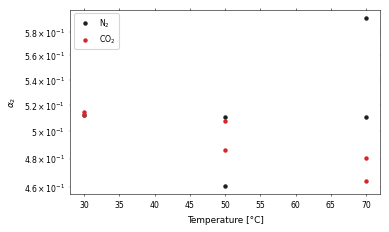

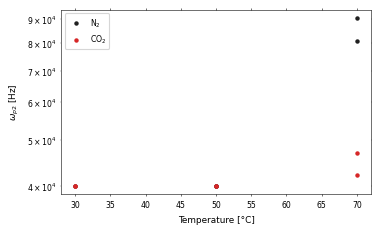

IndexError: index 6 is out of bounds for axis 0 with size 6

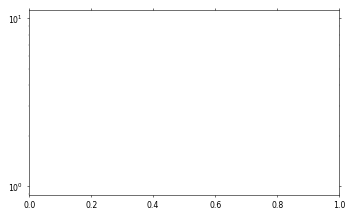

In [10]:
### plot final fit parameters against temperature

look_at = range(0,7)

for p in look_at :
    plt.yscale('log')

    for gas in GASES :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            x = P_ALL_[j][p][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        plt.scatter(v[0], v[1], linewidths=2, label=gas)
        #plt.errorbar(v[0], v[1], yerr=v[2:], fmt='none')

    plt.xlabel("Temperature [°C]")
    plt.ylabel(p_labels[p])
    plt.legend()
    plt.show()
